# LLM Application Pipeline

This notebook demonstrates how to serve [**Hugging Face**](https://huggingface.co/) LLM models using [**MLRun Serving**](https://docs.mlrun.org/en/stable/serving/serving-graph.html).

> Make sure you went over the basics in MLRun [**Quick Start Tutorial**](https://docs.mlrun.org/en/stable/tutorial/01-mlrun-basics.html) to understand the MLRun basics.

[MLRun serving](https://docs.mlrun.org/en/stable/serving/serving-graph.html) can produce managed ML application pipelines using real-time auto-scaling [Nuclio](https://nuclio.io/) serverless functions. The application pipeline includes all the steps from accepting events or data, preparing the required model features, inferencing results using one or more models, and driving actions.

The tutorial has 4 main steps:
1. [Define MLRun project and set all mlrun function](#project-setup)
2. [Create and test an application pipeline](#serving-function)
3. [Deploy the application pipeline](#deploy-serving)
4. [Create web front-end using Gradio](#deploy-gradio)


But first, please install the following requirements:

In [ ]:
%pip install -r requirements.txt

___
<a id="project-setup"></a>
## 1. Define MLRun project and set all mlrun function

Create or load an MLRun project that holds all your functions and configuration (see [project_setup.py](./src/project_setup.py))


In [15]:
import mlrun
from src.project_setup import create_and_set_project

project = create_and_set_project(
    git_source="git://github.com/yonishelach/learn-docs.git#main",
    name="mlopspedia",
    default_image="yonishelach/mlrun-hf-gpu",
    user_project=True,
)

> 2023-02-26 10:34:33,644 [info] loaded project huggingface from MLRun DB


Names with underscore '_' are about to be deprecated, use dashes '-' instead. Replacing underscores with dashes.


___
<a id="serving-function"></a>
## 2. Create and test an application pipeline

The application pipeline intercepts the user request through HTTP and responds with a processed result. It consists the following steps:
1. **Data Preprocessing** - Accept and process the incoming event, reformatting the input prompt as the LLM expects.
2. **LLM Inference** - Use the LLM to generate response by the given prompt.
3. **Data Postprocessing** - Process the prediction onto the next model - the toxicity classifier.
4. **Toxicity Classification** - Turn the model response into a user-friendly output message in case toxicity was detected.

You first create an MLRun serving function (specify the code, type, image, etc.). Then define a graph with the three steps. Finally, use the `plot()` method to visualize the application graph.

See the data `pre/post-processing` functions in [**serving.py**](./src/serving.py)

### 2.1. Define and Build the Serving Graph:
Get the serving function from our project:

In [16]:
serving_function = project.get_function("serving")

Define and visualize the serving graph:

In [3]:
# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

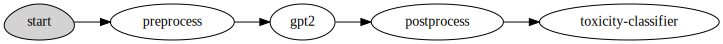

In [4]:
# Build the serving graph:
graph.to(handler="clean_preprocess", name="preprocess")\
     .to("LLMModelServer",
         name="gpt2",
         model_name="gpt2",
         model_class="GPT2LMHeadModel",
         tokenizer_name="gpt2",
         tokenizer_class="GPT2Tokenizer",
         use_deepspeed=False)\
     .to(handler="clean_postprocess", name="postprocess")\
     .to("ToxicityClassifierModelServer",
         name="toxicity-classifier",
         threshold=0.7).respond()

# Plot to graph:
serving_function.plot(rankdir='LR')

Save the serving function in the project:

In [19]:
# registering the serving 
project.set_function(serving_function, with_repo=True)
project.save()

### 2.2. Simulate the application pipeline locally

Creating a mocking server for testing:

In [20]:
server = serving_function.to_mock_server()

> 2023-02-26 10:34:36,557 [warning] run command, file or code were not specified


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

> 2023-02-26 10:34:37,589 [info] model sentiment-analysis was loaded


Test the `GPT2-Medium` knowledge on MLOps:

In [21]:
server.test(path='/predict', body="What are training pipelines?")["outputs"]

['The sentiment is POSITIVE', 'The prediction score is 0.5296593904495239']

___
<a id="deploy-serving"></a>
## 3. Deploy the application pipeline (serving function)

In [22]:
deployment = project.deploy_function(serving_function)

> 2023-02-26 10:34:39,323 [info] Starting remote function deploy
2023-02-26 10:34:39  (info) Deploying function
2023-02-26 10:34:39  (info) Building
2023-02-26 10:34:40  (info) Staging files and preparing base images
2023-02-26 10:34:40  (info) Building processor image
2023-02-26 10:36:55  (info) Build complete
2023-02-26 10:37:17  (info) Function deploy complete
> 2023-02-26 10:37:18,186 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-huggingface-davids-serving-pretrained.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['huggingface-davids-serving-pretrained-huggingface-davids.default-tenant.app.cto-office.iguazio-cd1.com/']}


___
<a id="deploy-gradio"></a>
## 4. Create web front-end using Gradio

[**Gradio**](https://gradio.app/) provides a fast way to build a friendly web interface to demonstrate your machine-learning model. You can use it to input the text, submit the request to the application pipeline (via HTTP), and show the results.

The following code defines a minimal app with an input box, a button, and two output boxes. The `launch()` method generates a local or remote web front-end application.

The application pipeline URL is taken from the deployment task output (`deployment.outputs['endpoint']`)

In [9]:
import gradio as gr
import requests

serving_url = deployment.outputs['endpoint']

def sentiment(text):
    # call the serving function with the input text
    resp = requests.post(serving_url, json={"text": text})
    return resp.json()

with gr.Blocks() as demo:
    input_box = [gr.Textbox(label="MLOps Subject to ask about:", placeholder="Please insert text", value="What are training pipelines?")]
    output = [gr.Textbox(label="Generated Answer")]
    greet_btn = gr.Button("Submit")
    greet_btn.click(fn=sentiment, inputs=input_box, outputs=output)

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://92916b6c-a3e6-42b3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


You can see the model results are not accurate enough. It is not quite the MLOps expert we wish it to be.

In the [next notebook](./02-llm-fine-tuning.ipynb), we will fine-tune the model with relevant data and see how its knowledge improve.

**Done!**